<a href="https://colab.research.google.com/github/slayerzeroa/Term_Project_23-2/blob/main/Term_Project_%EC%B5%9C%EC%A2%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 필요 라이브러리 정의



In [263]:
# Install the required libraries
# 라이브러리 설치
!pip install pandas-datareader --q
!pip install yfinance --q
!pip install hmmlearn --q

In [264]:
from datetime import datetime
import math
import warnings
import os

import numpy as np
import pandas as pd

from pandas_datareader import data as pdr
import yfinance as yf

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.graph_objs.scatter.marker import Line
from plotly.subplots import make_subplots
import plotly.express as px
from graphviz import Source
import graphviz
import seaborn as sns
from IPython.display import Image

from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from hmmlearn.hmm import GaussianHMM

import torch

# Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.tree import export_graphviz

from scipy.stats import randint

import google.colab
from google.colab import drive

%matplotlib inline

warnings.filterwarnings('ignore')

# 2. 데이터 수집

In [265]:
# 날짜 설정
start = datetime(2017, 1, 1)
end = datetime(2023, 1, 1)

# Yahoo Finance Overriding
yf.pdr_override()

In [266]:
# 학습 타겟 설정
target = 'BTC-USD'

[*********************100%%**********************]  2 of 2 completed


<Axes: title={'center': 'Stock prices of the considered asset'}, xlabel='Date'>

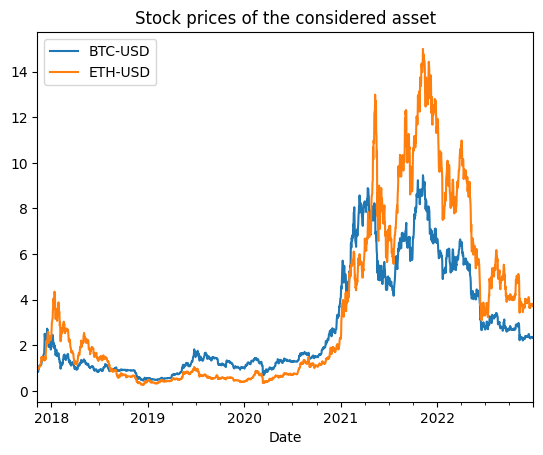

In [267]:
# 위험자산 설정
RISKY_ASSETS = ['BTC-USD', 'ETH-USD']

# Yahoo Finance에서 데이터를 수집함 (기간: start ~ end)
df = pdr.get_data_yahoo(RISKY_ASSETS, start, end)
df.columns.set_levels(['adj_close', 'close', 'high', 'low', 'open', 'volume'],level=0,inplace=True)
df = df.dropna()

# 수정종가 # 스케일링
df_adj = df['adj_close']/df.adj_close.iloc[0]

# 그래프 그리기
df_adj.plot(title='Stock prices of the considered asset')

In [268]:
df

adj_close                      close               \
                 BTC-USD      ETH-USD       BTC-USD      ETH-USD   
Date                                                               
2017-11-09   7143.580078   320.884003   7143.580078   320.884003   
2017-11-10   6618.140137   299.252991   6618.140137   299.252991   
2017-11-11   6357.600098   314.681000   6357.600098   314.681000   
2017-11-12   5950.069824   307.907990   5950.069824   307.907990   
2017-11-13   6559.490234   316.716003   6559.490234   316.716003   
...                  ...          ...           ...          ...   
2022-12-27  16717.173828  1212.791626  16717.173828  1212.791626   
2022-12-28  16552.572266  1189.986084  16552.572266  1189.986084   
2022-12-29  16642.341797  1201.595337  16642.341797  1201.595337   
2022-12-30  16602.585938  1199.232788  16602.585938  1199.232788   
2022-12-31  16547.496094  1196.771240  16547.496094  1196.771240   

                    high                        low               \
                 BTC-USD      ETH-USD       BTC-USD      ETH-USD   
Date                                                               
2017-11-09   7446.830078   329.451996   7101.520020   307.056000   
2017-11-10   7312.000000   324.717987   6436.870117   294.541992   
2017-11-11   6873.149902   319.453003   6204.220215   298.191986   
2017-11-12   6625.049805   319.153015   5519.009766   298.513000   
2017-11-13   6811.189941   328.415009   5844.290039   307.024994   
...                  ...          ...           ...          ...   
2022-12-27  16959.845703  1230.418091  16642.072266  1205.895630   
2022-12-28  16768.169922  1213.128906  16497.556641  1185.702148   
2022-12-29  16651.755859  1204.141602  16508.683594  1188.360229   
2022-12-30  16643.427734  1202.034668  16408.474609  1187.462524   
2022-12-31  16628.986328  1205.088623  16517.519531  1194.203735   

                    open                    volume                
                 BTC-USD      ETH-USD      BTC-USD       ETH-USD  
Date                                                              
2017-11-09   7446.830078   308.644989   3226249984  8.932500e+08  
2017-11-10   7173.729980   320.670990   5208249856  8.859860e+08  
2017-11-11   6618.609863   298.585999   4908680192  8.423010e+08  
2017-11-12   6295.450195   314.690002   8957349888  1.613480e+09  
2017-11-13   5938.250000   307.024994   6263249920  1.041890e+09  
...                  ...          ...          ...           ...  
2022-12-27  16919.291016  1226.987061  15748580239  4.091531e+09  
2022-12-28  16716.400391  1212.736572  17005713920  4.991670e+09  
2022-12-29  16552.322266  1190.010132  14472237479  4.132234e+09  
2022-12-30  16641.330078  1201.569580  15929162910  4.055668e+09  
2022-12-31  16603.673828  1199.360107  11239186456  3.018513e+09  

[1879 rows x 12 columns]

In [269]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 3. 필요한 클래스 및 함수 정의

In [270]:
class RegimeDetection:

    def get_regimes_hmm(self, input_data, params):
        hmm_model = self.initialise_model(GaussianHMM(), params).fit(input_data)
        return hmm_model

    def get_regimes_clustering(self, params):
        clustering =  self.initialise_model(AgglomerativeClustering(), params)
        return clustering

    def get_regimes_gmm(self, input_data, params):
        gmm = self.initialise_model(GaussianMixture(), params).fit(input_data)
        return gmm

    def initialise_model(self, model, params):
        for parameter, value in params.items():
            setattr(model, parameter, value)
        return model

In [271]:
def plot_hidden_states(hidden_states, prices_df, title=None):

    '''
    Input:
    hidden_states(numpy.ndarray) - array of predicted hidden states
    prices_df(df) - dataframe of close prices

    Output:
    Graph showing hidden states and prices

    '''

    colors = ['blue', 'green']
    n_components = len(np.unique(hidden_states))
    fig = go.Figure()

    for i in range(n_components):
        mask = hidden_states == i
        print('Number of observations for State ', i,":", len(prices_df.index[mask]))

        fig.add_trace(go.Scatter(x=prices_df.index[mask], y=prices_df[f"{prices_df.columns[0]}"][mask],
                    mode='markers',  name='Hidden State ' + str(i), marker=dict(size=4,color=colors[i])))
    print()
    fig.update_layout(title_text=title, title_x=0.5, height=400, width=900, legend=dict(
            yanchor="top", y=0.99, xanchor="left",x=0.01), margin=dict(l=20, r=20, t=30, b=20)).show()

In [272]:
def calculate_ma(prices: pd.DataFrame, rolling_num: int):
  return prices.iloc[:, 0].rolling(rolling_num).mean()

In [273]:
def prepare_input_data(prices, rolling_num):
    # 종목명
    ticker = prices.columns[0]
    # Moving Average, Log Return, MA Difference 계산
    # prices[f'{ticker}_ma{rolling_num}'] = np.log(prices).rolling(rolling_num).mean()
    prices[f'{ticker}_ma{rolling_num}'] = calculate_ma(prices, rolling_num)
    prices[f'{ticker}_log_return'] = np.log(prices[f'{ticker}_ma{rolling_num}']/prices[f'{ticker}_ma{rolling_num}'].shift(1)).dropna()
    prices[f'{ticker}_ma_diff'] = calculate_ma(prices, rolling_num) - calculate_ma(prices, rolling_num+50)
    # print(prices)

    # 골든크로스, 데드크로스 라벨링
    prices['Label'] = np.sign(prices[f'{ticker}_ma_diff'])
    prices['Label'][prices['Label'] == -1] = 0

    prices.dropna(inplace = True)
    prices_array = np.array([[q] for q in prices[f'{ticker}_log_return'].values])

    return prices, prices_array

# 4. 데이터 전처리 및 EDA

In [274]:
prices, prices_array = prepare_input_data(df['adj_close'].iloc[:, 0].to_frame(), 20)
prices

,BTC-USD,BTC-USD_ma20,BTC-USD_log_return,BTC-USD_ma_diff,Label
Date,,,,,
2018-01-17,11188.599609,14469.734961,-0.011741,1631.470271,1.0
2018-01-18,11474.900391,14310.669971,-0.011054,1410.529276,1.0
2018-01-19,11607.400391,14243.429980,-0.004710,1272.014139,1.0
2018-01-20,12899.200195,14180.569971,-0.004423,1115.702699,1.0
2018-01-21,11600.099609,14077.714941,-0.007280,932.132959,1.0
...,...,...,...,...,...
2022-12-27,16717.173828,17004.295215,-0.000385,-800.007073,0.0
2022-12-28,16552.572266,16970.250098,-0.002004,-797.095578,0.0
2022-12-29,16642.341797,16945.709570,-0.001447,-787.187556,0.0


In [275]:
plot_hidden_states(prices['Label'], prices[[f'{target}']], "Price & Label")

Number of observations for State  0 : 1012
Number of observations for State  1 : 798



# 5. 시장 국면 분석: 비지도 학습

In [276]:
regime_detection = RegimeDetection()

In [277]:
params = {'n_clusters': 2, 'linkage': 'complete',  'metric': 'manhattan', 'random_state':10}
clustering = regime_detection.get_regimes_clustering(params)
clustering_states = clustering.fit_predict(prices_array)

plot_hidden_states(np.array(clustering_states), prices[[f'{target}']], "Hierarchical Clustering")

Number of observations for State  0 : 1345
Number of observations for State  1 : 465



In [278]:
params = {'n_components':2, 'covariance_type': 'full', 'max_iter': 100000, 'n_init': 30,'init_params': 'kmeans', 'random_state':10}

gmm_model = regime_detection.get_regimes_gmm(prices_array, params)
gmm_states = gmm_model.predict(prices_array)
plot_hidden_states(np.array(gmm_states), prices[[f'{target}']], 'Gaussian Mixture Model')

Number of observations for State  0 : 1293
Number of observations for State  1 : 517



In [279]:
params = {'n_components':2, 'covariance_type':"full", 'random_state':10}

hmm_model = regime_detection.get_regimes_hmm(prices_array, params)
hmm_states = hmm_model.predict(prices_array)
plot_hidden_states(np.array(hmm_states), prices[[f'{target}']], 'Hidden Markov Model')

Number of observations for State  0 : 819
Number of observations for State  1 : 991



# 6. 시장 국면 분석: Random Forest

In [280]:
# google drive 접근

# 손 라벨링
label = pd.read_csv('/content/gdrive/Othercomputers/내 노트북/바탕 화면/SCHOOL LIFE/UNIVERSITY/과제쓰/4-1/인공지능기초/데이터/BTC-USD.csv', encoding='cp949')

In [281]:
# 골든 크로스, 데드 크로스 라벨링

In [282]:
label['Date'] = pd.to_datetime(label['Date'])

label[label['Date'] >= datetime(2017, 12 ,8)]['Label']

9       1
10      1
11      1
12      1
13      1
       ..
1854    0
1855    0
1856    0
1857    0
1858    0
Name: Label, Length: 1850, dtype: int64

In [283]:
prices['Label'] = list(label[label['Date'] >= prices.index[0]]['Label'])

In [284]:
rf_prices = copy.deepcopy(prices)
rf_prices['BTC-USD'] = rf_prices['BTC-USD'].shift(1)
rf_prices['BTC-USD_ma20'] = rf_prices['BTC-USD_ma20'].shift(1)
rf_prices['BTC-USD_log_return'] = rf_prices['BTC-USD_log_return'].shift(1)
rf_prices['BTC-USD_ma_diff'] = rf_prices['BTC-USD_ma_diff'].shift(1)

rf_prices.dropna()

,BTC-USD,BTC-USD_ma20,BTC-USD_log_return,BTC-USD_ma_diff,Label
Date,,,,,
2018-01-18,11188.599609,14469.734961,-0.011741,1631.470271,0
2018-01-19,11474.900391,14310.669971,-0.011054,1410.529276,0
2018-01-20,11607.400391,14243.429980,-0.004710,1272.014139,0
2018-01-21,12899.200195,14180.569971,-0.004423,1115.702699,0
2018-01-22,11600.099609,14077.714941,-0.007280,932.132959,0
...,...,...,...,...,...
2022-12-27,16919.804688,17010.842871,-0.000499,-830.848591,0
2022-12-28,16717.173828,17004.295215,-0.000385,-800.007073,0
2022-12-29,16552.572266,16970.250098,-0.002004,-797.095578,0


In [285]:
# Split the data into features (X) and target (y)
X = prices.drop(['Label', 'BTC-USD_ma_diff'], axis=1)
y = prices['Label']

# Split the data into training and test sets


# Non - Shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [286]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [287]:
y_pred = rf.predict(X_test)

In [288]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.574585635359116


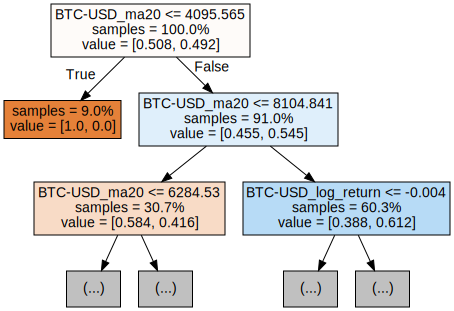

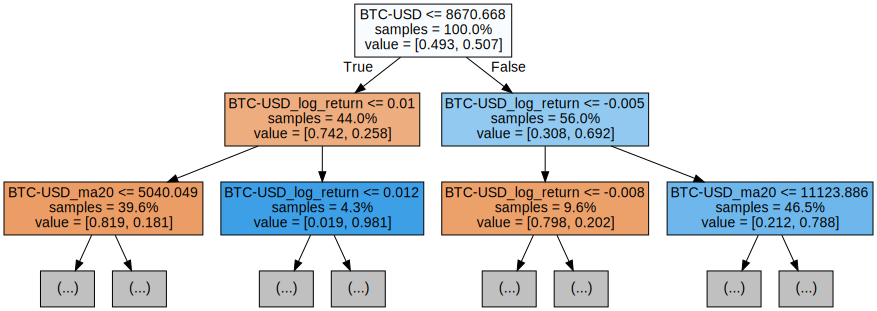

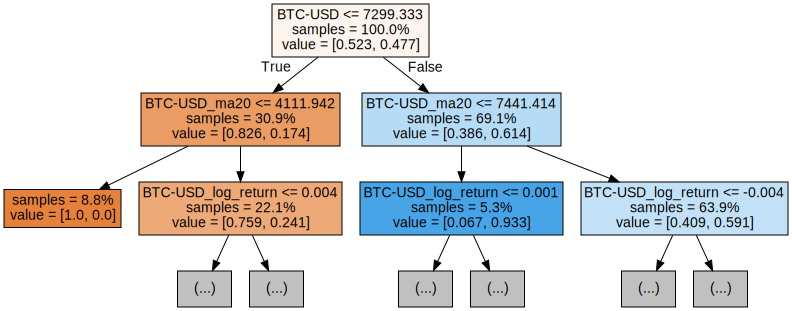

In [289]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [290]:
all_pred = rf.predict(X)

plot_hidden_states(np.array(y_pred), prices[[f'{target}']].iloc[-len(y_pred):], "Random Forest No Lag")

Number of observations for State  0 : 231
Number of observations for State  1 : 312



([0, 1, 2],
 [Text(0, 0, 'BTC-USD'),
  Text(1, 0, 'BTC-USD_ma20'),
  Text(2, 0, 'BTC-USD_log_return')])

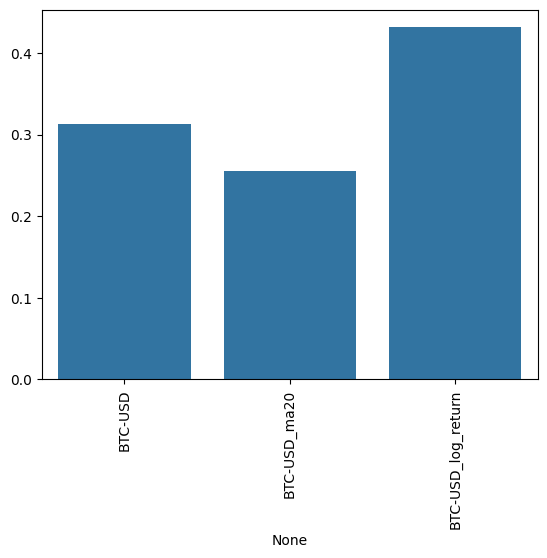

In [291]:
# Features 중요도 시각화
sns.barplot(x = X.columns, y = rf.feature_importances_)
plt.xticks(rotation = 90)

In [292]:
# Shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

all_pred = rf.predict(X)

plot_hidden_states(np.array(all_pred), prices[[f'{target}']])

Accuracy: 0.8950276243093923
Number of observations for State  0 : 1095
Number of observations for State  1 : 715



In [293]:
# Non-Shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

all_pred = rf.predict(X)

plot_hidden_states(np.array(all_pred), prices[[f'{target}']])

Accuracy: 0.570902394106814
Number of observations for State  0 : 869
Number of observations for State  1 : 941



# LSTM

In [294]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [295]:
# google drive 접근

rf = pd.read_csv("/content/gdrive/Othercomputers/내 노트북/바탕 화면/SCHOOL LIFE/UNIVERSITY/과제쓰/4-1/인공지능기초/데이터/10rf.csv", skiprows=10)
bitcoin_supply = pd.read_csv("/content/gdrive/Othercomputers/내 노트북/바탕 화면/SCHOOL LIFE/UNIVERSITY/과제쓰/4-1/인공지능기초/데이터/bitcoin_supply.csv", skiprows=1)

# rf = pd.read_csv("10rf.csv", skiprows=10)
# bitcoin_supply = pd.read_csv("bitcoin_supply.csv", skiprows=1)

rf.columns = ['Date', 'Rate']
rf = rf.set_index('Date')


bitcoin_supply.columns = ['Date', 'Supply', 'Inflation']
bitcoin_supply = bitcoin_supply.set_index('Date')

rf.index = pd.to_datetime(rf.index)
bitcoin_supply.index = pd.to_datetime(bitcoin_supply.index)

In [296]:
prices_1 = prices.join(bitcoin_supply, how='inner')
prices_1 = prices_1.join(rf, how='inner')

data = prices_1.dropna()

In [297]:
X = data.drop(['Supply', 'BTC-USD', 'Label'], axis=1)

y = data['Label']

In [298]:
X

,BTC-USD_ma20,BTC-USD_log_return,BTC-USD_ma_diff,Inflation,Rate
Date,,,,,
2018-01-17,14469.734961,-0.011741,1631.470271,4.533422,2.57
2018-01-18,14310.669971,-0.011054,1410.529276,4.695717,2.62
2018-01-19,14243.429980,-0.004710,1272.014139,4.477998,2.64
2018-01-22,13875.179980,-0.014491,667.142139,4.530491,2.66
2018-01-23,13658.550000,-0.015736,390.045724,4.801182,2.63
...,...,...,...,...,...
2022-12-23,17040.106348,-0.000326,-905.541392,1.565018,3.75
2022-12-27,17004.295215,-0.000385,-800.007073,1.363245,3.84
2022-12-28,16970.250098,-0.002004,-797.095578,1.991449,3.88


In [299]:
# scaling
from sklearn.preprocessing import MinMaxScaler

scaler_x = MinMaxScaler()

scaler_x.fit(X.values)

X_scale = scaler_x.transform(X.values)
X_scale = pd.DataFrame(X_scale, columns=X.columns, index=X.index)

X_scale

,BTC-USD_ma20,BTC-USD_log_return,BTC-USD_ma_diff,Inflation,Rate
Date,,,,,
2018-01-17,0.183565,0.277409,0.594006,0.878911,0.549598
2018-01-18,0.180897,0.289479,0.585259,0.920108,0.563003
2018-01-19,0.179770,0.400859,0.579774,0.864842,0.568365
2018-01-22,0.173593,0.229127,0.555825,0.878167,0.573727
2018-01-23,0.169960,0.207278,0.544854,0.946879,0.565684
...,...,...,...,...,...
2022-12-23,0.226674,0.477811,0.493556,0.125411,0.865952
2022-12-27,0.226074,0.476784,0.497735,0.074193,0.890080
2022-12-28,0.225503,0.448358,0.497850,0.233656,0.900804


In [300]:
# X_train, X_test, y_train, y_test = train_test_split(X_scale, y_scale[0], test_size=0.3, shuffle=False)

In [301]:
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.3, shuffle=False)

In [302]:
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

# 텐서로 변환
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.FloatTensor(y_train.values)

X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.FloatTensor(y_test.values)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(X_train_tensor, y_train_tensor)

# 데이터 로더
dataloader = DataLoader(dataset,
                        batch_size=32,
                        shuffle=False,
                        drop_last=True)

In [303]:
# 하이퍼파라미터
data_dim = 5
hidden_dim = 100
output_dim = 1
learning_rate = 0.0001
nb_epochs = 1000
seq_length = len(X_train)

class Net(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            # dropout = 0.1,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True)
        self.sigmoid = nn.Sigmoid()

    # 학습 초기화를 위한 함수
    def reset_hidden_state(self):
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))

    # 예측을 위한 함수
    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        x = self.sigmoid(x)
        return x

In [304]:
def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
    criterion = nn.MSELoss().to()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs

    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        for batch_idx, samples in enumerate(train_df):
            x_train, y_train = samples
            # seq별 hidden state reset
            model.reset_hidden_state()
            # H(x) 계산
            outputs = model(x_train)
            # cost 계산
            loss = criterion(outputs, y_train)
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_cost += loss/total_batch
        train_hist[epoch] = avg_cost
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))

        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                break

    return model.eval(), train_hist

In [305]:
# 모델 학습
net = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to()
none_lag_model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 20, patience = 10)
torch.save(none_lag_model, 'none_lag_model.pt')

Epoch: 0000 train loss : 0.2507
Epoch: 0020 train loss : 0.2479
Epoch: 0040 train loss : 0.2441
Epoch: 0060 train loss : 0.2383
Epoch: 0080 train loss : 0.2300
Epoch: 0100 train loss : 0.2196
Epoch: 0120 train loss : 0.2082
Epoch: 0140 train loss : 0.1975
Epoch: 0160 train loss : 0.1885
Epoch: 0180 train loss : 0.1815
Epoch: 0200 train loss : 0.1761
Epoch: 0220 train loss : 0.1719
Epoch: 0240 train loss : 0.1685
Epoch: 0260 train loss : 0.1657
Epoch: 0280 train loss : 0.1633
Epoch: 0300 train loss : 0.1612
Epoch: 0320 train loss : 0.1592
Epoch: 0340 train loss : 0.1575
Epoch: 0360 train loss : 0.1559
Epoch: 0380 train loss : 0.1545
Epoch: 0400 train loss : 0.1532
Epoch: 0420 train loss : 0.1521
Epoch: 0440 train loss : 0.1511
Epoch: 0460 train loss : 0.1502
Epoch: 0480 train loss : 0.1494
Epoch: 0500 train loss : 0.1488
Epoch: 0520 train loss : 0.1482
Epoch: 0540 train loss : 0.1477
Epoch: 0560 train loss : 0.1473
Epoch: 0580 train loss : 0.1469
Epoch: 0600 train loss : 0.1465
Epoch: 0

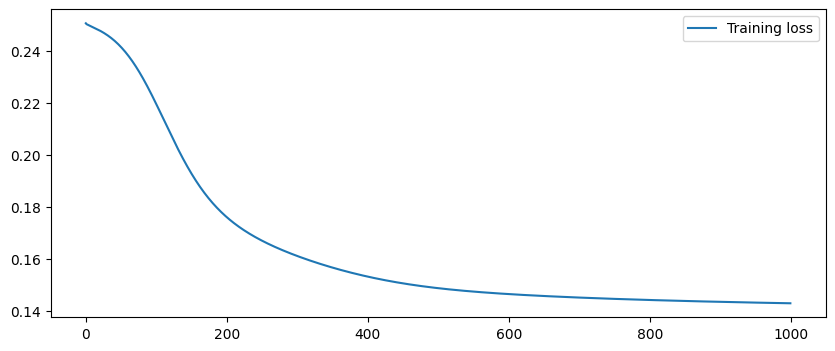

In [306]:
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

In [307]:
def step_function(number):
  if number > 0.5:
    number = 1
  else:
    number = 0
  return number

In [308]:
prices_1 = prices.loc[X.index]
prices_1

,BTC-USD,BTC-USD_ma20,BTC-USD_log_return,BTC-USD_ma_diff,Label
Date,,,,,
2018-01-17,11188.599609,14469.734961,-0.011741,1631.470271,0
2018-01-18,11474.900391,14310.669971,-0.011054,1410.529276,0
2018-01-19,11607.400391,14243.429980,-0.004710,1272.014139,0
2018-01-22,10931.400391,13875.179980,-0.014491,667.142139,0
2018-01-23,10868.400391,13658.550000,-0.015736,390.045724,0
...,...,...,...,...,...
2022-12-23,16796.953125,17040.106348,-0.000326,-905.541392,0
2022-12-27,16717.173828,17004.295215,-0.000385,-800.007073,0
2022-12-28,16552.572266,16970.250098,-0.002004,-797.095578,0


In [309]:
X_test

,BTC-USD_ma20,BTC-USD_log_return,BTC-USD_ma_diff,Inflation,Rate
Date,,,,,
2021-07-07,0.513423,0.375921,0.260146,0.108023,0.217158
2021-07-08,0.510983,0.408558,0.266081,0.157421,0.209115
2021-07-09,0.509459,0.436535,0.276030,0.132696,0.227882
2021-07-12,0.510327,0.500361,0.318095,0.117201,0.230563
2021-07-13,0.509471,0.457126,0.327743,0.148060,0.241287
...,...,...,...,...,...
2022-12-23,0.226674,0.477811,0.493556,0.125411,0.865952
2022-12-27,0.226074,0.476784,0.497735,0.074193,0.890080
2022-12-28,0.225503,0.448358,0.497850,0.233656,0.900804


In [310]:
# 예측 테스트
with torch.no_grad():
    none_lag_pred = []
    # for pr in X_train_tensor:

    #     model.reset_hidden_state()

    #     predicted = model(torch.unsqueeze(pr, 0))
    #     predicted = torch.flatten(predicted).item()
    #     pred.append(step_function(predicted))

    for pr in X_test_tensor:

        none_lag_model.reset_hidden_state()

        predicted = none_lag_model(torch.unsqueeze(pr, 0))
        predicted = torch.flatten(predicted).item()
        none_lag_pred.append(step_function(predicted))

# def MAE(true, pred):
#     return np.mean(np.abs(true-pred))

# print('MAE SCORE : ', MAE(pred, y_test))

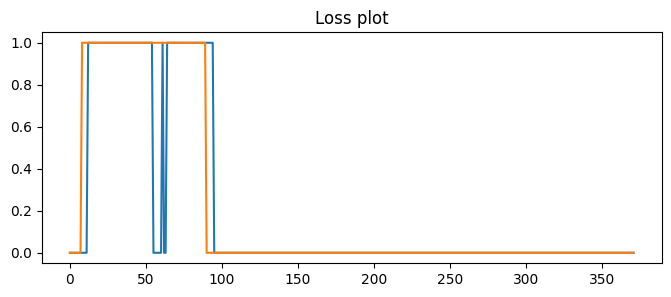

In [311]:
fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(none_lag_pred)), none_lag_pred, label = 'pred')
plt.plot(np.arange(len(list(y_test))), list(y_test), label = 'true')
plt.title("Loss plot")
plt.show()

In [312]:
y_test

Date
2021-07-07    0
2021-07-08    0
2021-07-09    0
2021-07-12    0
2021-07-13    0
             ..
2022-12-23    0
2022-12-27    0
2022-12-28    0
2022-12-29    0
2022-12-30    0
Name: Label, Length: 372, dtype: int64

In [313]:
accuracy = accuracy_score(list(y_test), none_lag_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9543010752688172


In [314]:
plot_hidden_states(np.array(none_lag_pred), prices_1[[f'{target}']][-len(y_test):], "LSTM No Lag")

Number of observations for State  0 : 297
Number of observations for State  1 : 75



#Lag 1

In [315]:
# shift 1 lagged 데이터 생성
prices_1 = prices.join(bitcoin_supply, how='inner')
prices_1 = prices_1.join(rf, how='inner')

data = prices_1.dropna()

prices_1_lagged = prices_1.shift(1)
prices_1_lagged.Label = prices_1.Label
prices_1_lagged = prices_1_lagged.dropna()
prices_1_lagged

,BTC-USD,BTC-USD_ma20,BTC-USD_log_return,BTC-USD_ma_diff,Label,Supply,Inflation,Rate
Date,,,,,,,,
2018-01-18,11188.599609,14469.734961,-0.011741,1631.470271,0,16809202.30,4.533422,2.57
2018-01-19,11474.900391,14310.669971,-0.011054,1410.529276,0,16811364.80,4.695717,2.62
2018-01-22,11607.400391,14243.429980,-0.004710,1272.014139,0,16813427.30,4.477998,2.64
2018-01-23,10931.400391,13875.179980,-0.014491,667.142139,0,16820077.30,4.530491,2.66
2018-01-24,10868.400391,13658.550000,-0.015736,390.045724,0,16822289.80,4.801182,2.63
...,...,...,...,...,...,...,...,...
2022-12-23,16830.341797,17045.670508,-0.000757,-934.101562,0,19240989.79,1.600657,3.67
2022-12-26,16796.953125,17040.106348,-0.000326,-905.541392,0,19241814.79,1.565018,3.75
2022-12-28,16717.173828,17004.295215,-0.000385,-800.007073,0,19244777.29,1.363245,3.84


In [316]:
X = prices_1_lagged.drop(['Supply', 'BTC-USD', 'Label'], axis=1)

y = prices_1_lagged['Label']

In [317]:
# scaling
from sklearn.preprocessing import MinMaxScaler

scaler_x = MinMaxScaler()

scaler_x.fit(X.values)

X_scale = scaler_x.transform(X.values)
X_scale = pd.DataFrame(X_scale, columns=X.columns, index=X.index)

X_scale

,BTC-USD_ma20,BTC-USD_log_return,BTC-USD_ma_diff,Inflation,Rate
Date,,,,,
2018-01-18,0.183565,0.277409,0.594006,0.878911,0.549598
2018-01-19,0.180897,0.289479,0.585259,0.920108,0.563003
2018-01-22,0.179770,0.400859,0.579774,0.864842,0.568365
2018-01-23,0.173593,0.229127,0.555825,0.878167,0.573727
2018-01-24,0.169960,0.207278,0.544854,0.946879,0.565684
...,...,...,...,...,...
2022-12-23,0.226768,0.470245,0.492425,0.134458,0.844504
2022-12-26,0.226674,0.477811,0.493556,0.125411,0.865952
2022-12-28,0.226074,0.476784,0.497735,0.074193,0.890080


In [318]:
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2, shuffle=False)

from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

# 텐서로 변환
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.FloatTensor(y_train.values)

X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.FloatTensor(y_test.values)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(X_train_tensor, y_train_tensor)

# 데이터 로더
dataloader = DataLoader(dataset,
                        batch_size=32,
                        shuffle=False,
                        drop_last=True)

In [319]:
# 하이퍼파라미터
data_dim = 5
hidden_dim = 100
output_dim = 1
learning_rate = 0.0001
nb_epochs = 1000
seq_length = len(X_train)

class Net(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            # dropout = 0.1,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True)
        self.sigmoid = nn.Sigmoid()

    # 학습 초기화를 위한 함수
    def reset_hidden_state(self):
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))

    # 예측을 위한 함수
    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        x = self.sigmoid(x)
        return x

In [320]:
def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):

    criterion = nn.MSELoss().to()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs

    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        for batch_idx, samples in enumerate(train_df):
            x_train, y_train = samples
            # seq별 hidden state reset
            model.reset_hidden_state()
            # H(x) 계산
            outputs = model(x_train)
            # cost 계산
            loss = criterion(outputs, y_train)
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_cost += loss/total_batch
        train_hist[epoch] = avg_cost
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))

        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                break

    return model.eval(), train_hist

In [321]:
# 모델 학습
net = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to()
lag_1_model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 10, patience = 10)
torch.save(lag_1_model, 'lag_1_model.pt')

Epoch: 0000 train loss : 0.2521
Epoch: 0010 train loss : 0.2497
Epoch: 0020 train loss : 0.2473
Epoch: 0030 train loss : 0.2444
Epoch: 0040 train loss : 0.2409
Epoch: 0050 train loss : 0.2366
Epoch: 0060 train loss : 0.2315
Epoch: 0070 train loss : 0.2256
Epoch: 0080 train loss : 0.2192
Epoch: 0090 train loss : 0.2125
Epoch: 0100 train loss : 0.2058
Epoch: 0110 train loss : 0.1996
Epoch: 0120 train loss : 0.1941
Epoch: 0130 train loss : 0.1893
Epoch: 0140 train loss : 0.1853
Epoch: 0150 train loss : 0.1818
Epoch: 0160 train loss : 0.1789
Epoch: 0170 train loss : 0.1765
Epoch: 0180 train loss : 0.1744
Epoch: 0190 train loss : 0.1726
Epoch: 0200 train loss : 0.1709
Epoch: 0210 train loss : 0.1695
Epoch: 0220 train loss : 0.1682
Epoch: 0230 train loss : 0.1670
Epoch: 0240 train loss : 0.1659
Epoch: 0250 train loss : 0.1649
Epoch: 0260 train loss : 0.1639
Epoch: 0270 train loss : 0.1630
Epoch: 0280 train loss : 0.1621
Epoch: 0290 train loss : 0.1612
Epoch: 0300 train loss : 0.1604
Epoch: 0

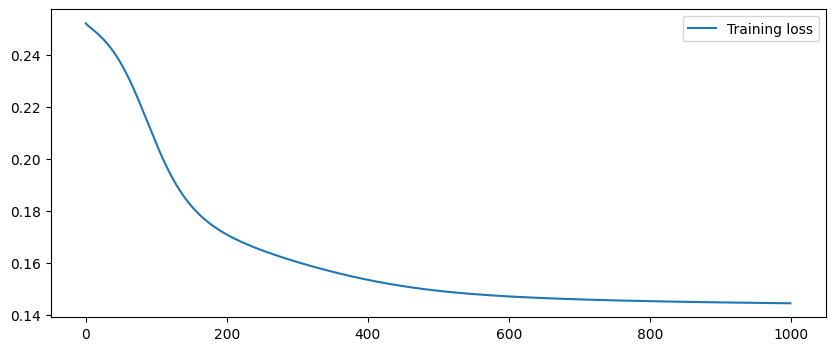

In [322]:
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

In [323]:
# 예측 테스트
with torch.no_grad():
    lag_1_pred = []
    for pr in X_train_tensor:
        lag_1_model.reset_hidden_state()
        lag_1_predicted = lag_1_model(torch.unsqueeze(pr, 0))
        lag_1_predicted = torch.flatten(lag_1_predicted).item()
        lag_1_pred.append(step_function(lag_1_predicted))

    for pr in X_test_tensor:
        lag_1_model.reset_hidden_state()
        lag_1_predicted = lag_1_model(torch.unsqueeze(pr, 0))
        lag_1_predicted = torch.flatten(lag_1_predicted).item()
        lag_1_pred.append(step_function(lag_1_predicted))

# def MAE(true, pred):
#     return np.mean(np.abs(true-pred))

# print('MAE SCORE : ', MAE(pred, y_test))

In [355]:
accuracy = accuracy_score(list(y_test), lag_1_pred[-len(y_test):])
print("Accuracy:", accuracy)

Accuracy: 0.9516129032258065


In [354]:
plot_hidden_states(np.array(lag_1_pred[-len(y_test):]), prices_1_lagged[[f'{target}']][-len(y_test):], "LSTM 1 Lag")

Number of observations for State  0 : 275
Number of observations for State  1 : 97



In [326]:
print(len(prices_1_lagged[prices_1_lagged['Label']==0]))
print(len(prices_1_lagged[prices_1_lagged['Label']==1]))

726
513


# Lag 2

In [327]:
# shift 2 lagged 데이터 생성
prices_2 = prices.join(bitcoin_supply, how='inner')
prices_2 = prices_2.join(rf, how='inner')

data = prices_2.dropna()

prices_2_lagged = prices_2.shift(2)
prices_2_lagged.Label = prices_2.Label
prices_2_lagged = prices_2_lagged.dropna()
prices_2_lagged

,BTC-USD,BTC-USD_ma20,BTC-USD_log_return,BTC-USD_ma_diff,Label,Supply,Inflation,Rate
Date,,,,,,,,
2018-01-19,11188.599609,14469.734961,-0.011741,1631.470271,0,16809202.30,4.533422,2.57
2018-01-22,11474.900391,14310.669971,-0.011054,1410.529276,0,16811364.80,4.695717,2.62
2018-01-23,11607.400391,14243.429980,-0.004710,1272.014139,0,16813427.30,4.477998,2.64
2018-01-24,10931.400391,13875.179980,-0.014491,667.142139,0,16820077.30,4.530491,2.66
2018-01-25,10868.400391,13658.550000,-0.015736,390.045724,0,16822289.80,4.801182,2.63
...,...,...,...,...,...,...,...,...
2022-12-23,16817.535156,17058.586426,-0.000438,-957.650823,0,19240146.04,1.695590,3.68
2022-12-26,16830.341797,17045.670508,-0.000757,-934.101562,0,19240989.79,1.600657,3.67
2022-12-27,16796.953125,17040.106348,-0.000326,-905.541392,0,19241814.79,1.565018,3.75


In [328]:
X = prices_2_lagged.drop(['Supply', 'BTC-USD', 'Label'], axis=1)

y = prices_2_lagged['Label']

In [329]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

# 텐서로 변환
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.FloatTensor(y_train.values)

X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.FloatTensor(y_test.values)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(X_train_tensor, y_train_tensor)

# 데이터 로더
dataloader = DataLoader(dataset,
                        batch_size=32,
                        shuffle=False,
                        drop_last=True)

In [330]:
# 모델 학습
net = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to()
lag_2_model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 20, patience = 10)
torch.save(lag_2_model, 'lag_2_model.pt')

Epoch: 0000 train loss : 0.2655
Epoch: 0020 train loss : 0.2369
Epoch: 0040 train loss : 0.2277
Epoch: 0060 train loss : 0.2205
Epoch: 0080 train loss : 0.2133
Epoch: 0100 train loss : 0.2082
Epoch: 0120 train loss : 0.2040
Epoch: 0140 train loss : 0.2006
Epoch: 0160 train loss : 0.1981
Epoch: 0180 train loss : 0.1961
Epoch: 0200 train loss : 0.1946
Epoch: 0220 train loss : 0.1931
Epoch: 0240 train loss : 0.1924
Epoch: 0260 train loss : 0.1907

 Early Stopping


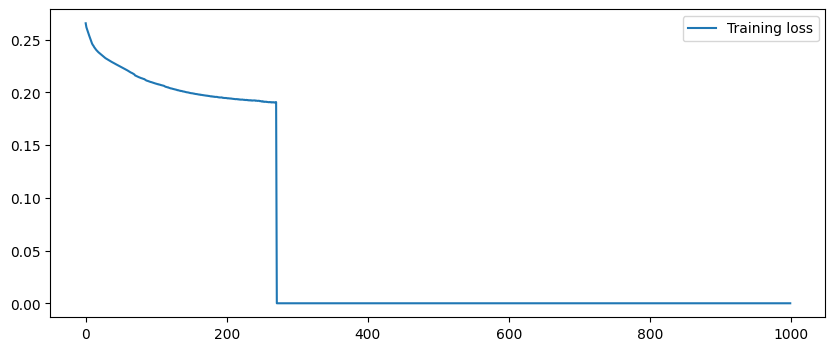

In [331]:
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

In [332]:
# 예측 테스트
with torch.no_grad():
    lag_2_pred = []
    for pr in X_train_tensor:
        lag_2_model.reset_hidden_state()
        lag_2_predicted = lag_2_model(torch.unsqueeze(pr, 0))
        lag_2_predicted = torch.flatten(lag_2_predicted).item()
        lag_2_pred.append(step_function(lag_2_predicted))

    for pr in range(len(X_test_tensor)):
        lag_2_model.reset_hidden_state()
        lag_2_predicted = lag_2_model(torch.unsqueeze(X_test_tensor[pr], 0))
        lag_2_predicted = torch.flatten(lag_2_predicted).item()
        lag_2_pred.append(step_function(lag_2_predicted))

# def MAE(true, pred):
#     return np.mean(np.abs(true-pred))

# print('MAE SCORE : ', MAE(pred, y_test))

In [356]:
accuracy = accuracy_score(list(y_test), lag_2_pred[-len(y_test):])
print("Accuracy:", accuracy)

Accuracy: 0.8360215053763441


In [334]:
plot_hidden_states(np.array(lag_2_pred[:len(y_test)]), prices_2_lagged[[f'{target}']][-len(y_test):], 'LSTM 2 Lag')

Number of observations for State  0 : 263
Number of observations for State  1 : 109



# Backtest

In [335]:
import copy

In [336]:
prices_1_lagged['BTC-USD_return'] = np.exp(prices_1_lagged['BTC-USD_log_return'])-1

In [337]:
prices_1_lagged['pred'] = lag_1_pred

In [338]:
down_1 = copy.deepcopy(prices_1_lagged[prices_1_lagged['Label'] == 0])
up_1 = copy.deepcopy(prices_1_lagged[prices_1_lagged['Label'] == 1])

In [339]:
down_1['BTC-USD_return'] = -down_1['BTC-USD_return']

In [340]:
lag_1_df = pd.concat([up_1, down_1])

In [341]:
lag_1_df = lag_1_df.sort_index()

In [342]:
prices_2_lagged['BTC-USD_return'] = np.exp(prices_2_lagged['BTC-USD_log_return'])-1
prices_2_lagged['pred'] = lag_2_pred
down = copy.deepcopy(prices_2_lagged[prices_2_lagged['Label'] == 0])
up = copy.deepcopy(prices_2_lagged[prices_2_lagged['Label'] == 1])
down['BTC-USD_return'] = -down['BTC-USD_return']
lag_2_df = pd.concat([up, down])
lag_2_df = lag_2_df.sort_index()

In [343]:
lag_1_df

,BTC-USD,BTC-USD_ma20,BTC-USD_log_return,BTC-USD_ma_diff,Label,Supply,Inflation,Rate,BTC-USD_return,pred
Date,,,,,,,,,,
2018-01-18,11188.599609,14469.734961,-0.011741,1631.470271,0,16809202.30,4.533422,2.57,0.011673,0
2018-01-19,11474.900391,14310.669971,-0.011054,1410.529276,0,16811364.80,4.695717,2.62,0.010993,0
2018-01-22,11607.400391,14243.429980,-0.004710,1272.014139,0,16813427.30,4.477998,2.64,0.004699,0
2018-01-23,10931.400391,13875.179980,-0.014491,667.142139,0,16820077.30,4.530491,2.66,0.014387,0
2018-01-24,10868.400391,13658.550000,-0.015736,390.045724,0,16822289.80,4.801182,2.63,0.015613,0
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,16830.341797,17045.670508,-0.000757,-934.101562,0,19240989.79,1.600657,3.67,0.000757,0
2022-12-26,16796.953125,17040.106348,-0.000326,-905.541392,0,19241814.79,1.565018,3.75,0.000326,0
2022-12-28,16717.173828,17004.295215,-0.000385,-800.007073,0,19244777.29,1.363245,3.84,0.000385,0


In [344]:
fee = 0.0025

In [345]:
carrying_return = np.cumprod((1+prices['BTC-USD_log_return']).iloc[-len(y_test):])[-1]-1
print(f'Carrying 누적 수익률: {carrying_return * 100}%')

Carrying 누적 수익률: -65.5654598448883%


In [346]:
lstm_return = np.cumprod((1+lag_1_df['BTC-USD_return']).iloc[-len(y_test):]-fee)[-1]-1
print(f'Lag 1 LSTM 누적 수익률: {lstm_return * 100}%')

Lag 1 LSTM 누적 수익률: 40.485294918480584%


In [347]:
lstm_return = np.cumprod((1+lag_2_df['BTC-USD_return']).iloc[-len(y_test):]-fee)[-1]-1
print(f'Lag 2 LSTM 누적 수익률: {lstm_return * 100}%')

Lag 2 LSTM 누적 수익률: 40.670032711787194%


In [348]:
lag_1_df

,BTC-USD,BTC-USD_ma20,BTC-USD_log_return,BTC-USD_ma_diff,Label,Supply,Inflation,Rate,BTC-USD_return,pred
Date,,,,,,,,,,
2018-01-18,11188.599609,14469.734961,-0.011741,1631.470271,0,16809202.30,4.533422,2.57,0.011673,0
2018-01-19,11474.900391,14310.669971,-0.011054,1410.529276,0,16811364.80,4.695717,2.62,0.010993,0
2018-01-22,11607.400391,14243.429980,-0.004710,1272.014139,0,16813427.30,4.477998,2.64,0.004699,0
2018-01-23,10931.400391,13875.179980,-0.014491,667.142139,0,16820077.30,4.530491,2.66,0.014387,0
2018-01-24,10868.400391,13658.550000,-0.015736,390.045724,0,16822289.80,4.801182,2.63,0.015613,0
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,16830.341797,17045.670508,-0.000757,-934.101562,0,19240989.79,1.600657,3.67,0.000757,0
2022-12-26,16796.953125,17040.106348,-0.000326,-905.541392,0,19241814.79,1.565018,3.75,0.000326,0
2022-12-28,16717.173828,17004.295215,-0.000385,-800.007073,0,19244777.29,1.363245,3.84,0.000385,0


In [349]:
%pip install pyfolio-reloaded --q

In [350]:
import pyfolio

Start date,2021-12-25
End date,2022-12-31
Total months,17
,Backtest
Annual return,-51.432%
Cumulative returns,-65.565%
Annual volatility,10.741%
Sharpe ratio,-6.66
Calmar ratio,-0.78
Stability,0.91
Max drawdown,-66.299%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,66.30,2021-12-26,2022-11-28,NaT,NaN
1,NaN,NaT,NaT,NaT,NaN
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


ConversionError: Failed to convert value(s) to axis units: (NaT, Timestamp('2022-12-31 00:00:00', freq='D'))

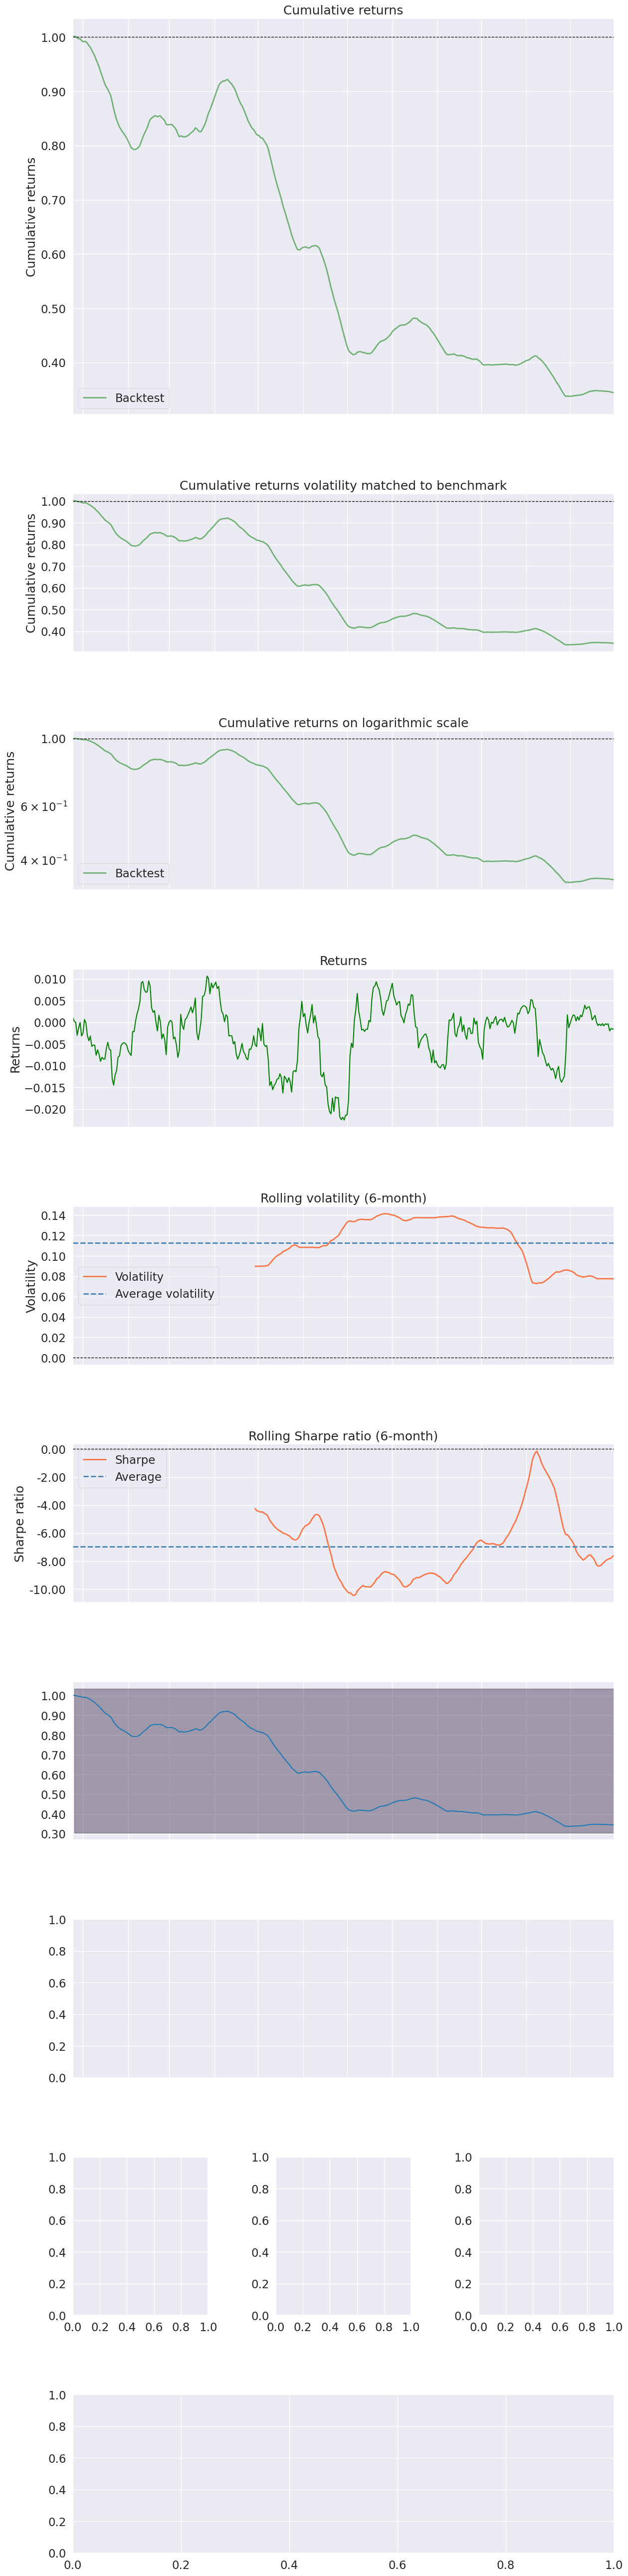

In [351]:
pyfolio.create_returns_tear_sheet(prices['BTC-USD_log_return'].iloc[-len(y_test):])

Start date,2021-07-07
End date,2022-12-30
Total months,17
,Backtest
Annual return,25.895%
Cumulative returns,40.485%
Annual volatility,10.703%
Sharpe ratio,2.21
Calmar ratio,1.28
Stability,0.64
Max drawdown,-20.245%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,20.25,2022-07-06,2022-11-09,NaT,NaN
1,20.22,2022-02-04,2022-04-11,2022-06-22,99
2,10.19,2021-09-02,2021-10-01,2021-10-21,36
3,4.39,2021-07-12,2021-07-26,2021-08-04,18
4,2.24,2021-11-04,2021-11-18,2021-12-02,21


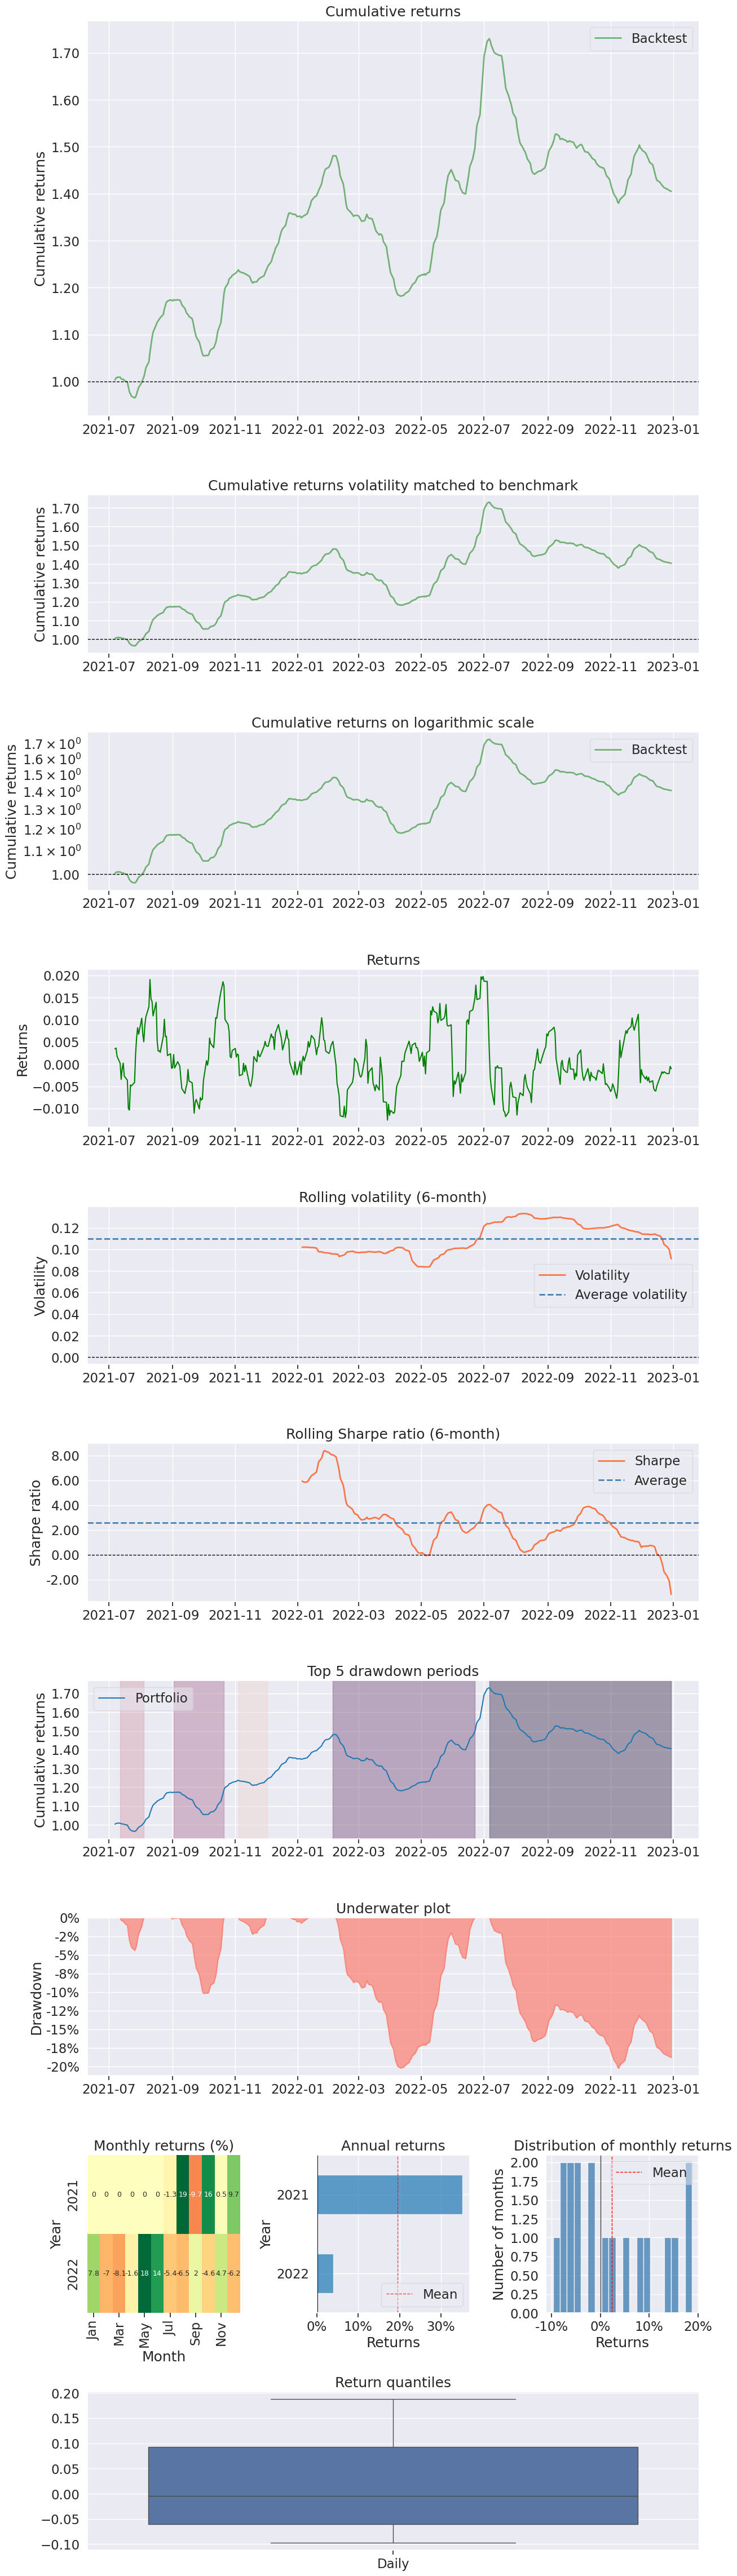

In [352]:
pyfolio.create_returns_tear_sheet(lag_1_df['BTC-USD_return'].iloc[-len(y_test):]-fee)

Start date,2021-07-06
End date,2022-12-30
Total months,17
,Backtest
Annual return,26.007%
Cumulative returns,40.67%
Annual volatility,10.701%
Sharpe ratio,2.21
Calmar ratio,1.28
Stability,0.65
Max drawdown,-20.245%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,20.25,2022-07-07,2022-11-10,NaT,NaN
1,20.22,2022-02-07,2022-04-12,2022-06-23,99
2,10.19,2021-09-03,2021-10-04,2021-10-22,36
3,4.35,2021-07-13,2021-07-27,2021-08-05,18
4,2.24,2021-11-05,2021-11-19,2021-12-03,21


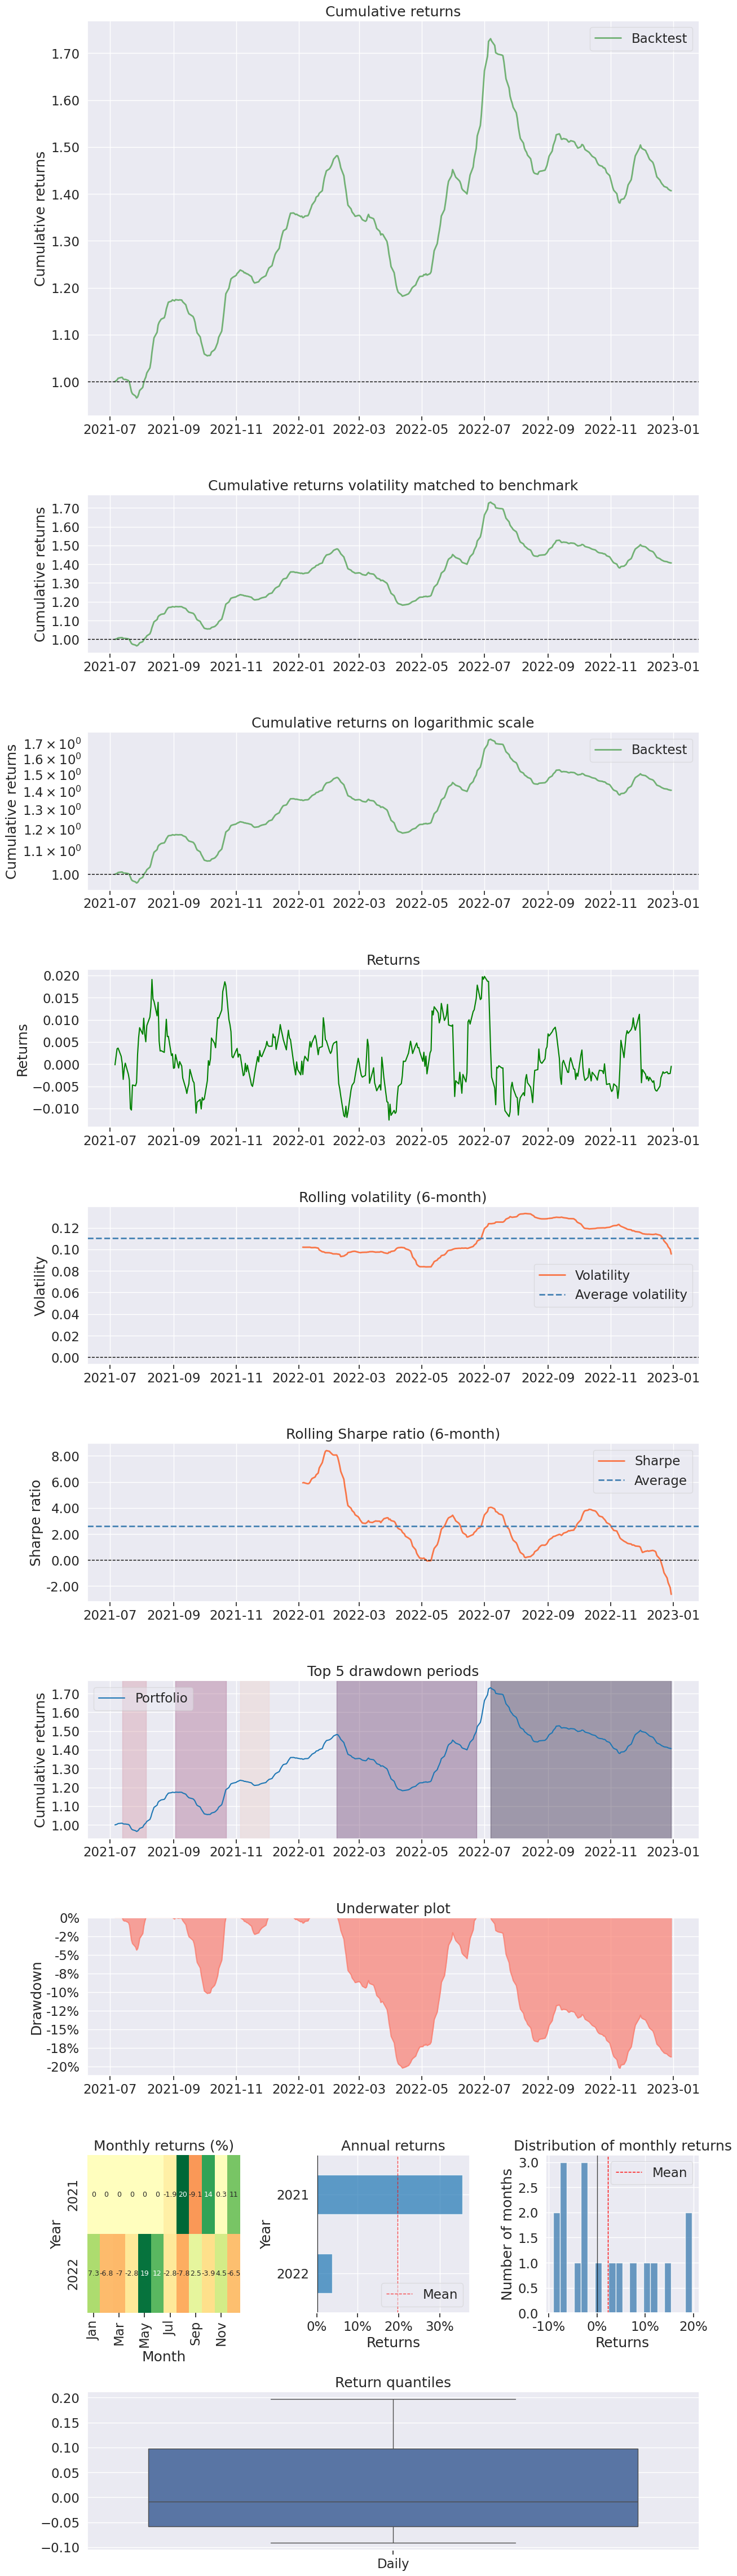

In [353]:
pyfolio.create_returns_tear_sheet(lag_2_df['BTC-USD_return'].iloc[-len(y_test):]-fee)